# 第4回: K近傍法 & 教師あり学習のお作法

このHands-onでは下記3種類のデータを用いて，K近傍法と教師あり学習のお作法について体験します．
* 手書き数字画像
* 人工的に作られたある2次元データ
* ある時期のアメリカ合衆国の年収調査データ

Hands-onに先立って，必要なライブラリを読み込んでおきます．


In [1]:
# 表形式のデータを操作するためのライブラリ
import pandas as pd

# 行列計算をおこなうためのライブラリ
import numpy as np

# データセット
from sklearn import datasets

# K近傍法を実行するためのクラス
from sklearn.neighbors import KNeighborsClassifier

# ロジスティック回帰を実行するためのクラス
from sklearn.linear_model import LogisticRegression

# 決定木を実行するためのクラス
from sklearn.tree import DecisionTreeClassifier

# 交差検証を行うためのクラス
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_validate

# 精度，マクロ精度，適合率，AUCを評価するための関数
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, roc_auc_score

# データ変換のためのクラス
import sklearn.preprocessing as preprocessing

# データ分割のための関数
from sklearn.model_selection import train_test_split

# グラフ描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

---
## 例題1: MNIST手書き数字データ

例題1では，K近傍法を用いて手書き数字の識別の体験をします．
用いるデータは，かの有名な[MNISTデータセット](http://yann.lecun.com/exdb/mnist/)です．
今回は，`scikit-learn`ライブラリに梱包された8x8ピクセルの領域に描かれた手書き数字のグレースケール画像のデータセットを用います．
データセット中の手書き数字は**0から9の数**に対応しています．
また，手書き画像データは**各ピクセルに0から255の数値**が割り当てられており，その数字によって白黒の濃淡がつけられています．

以下のコードを実行してMNISTデータセットを読み込みましょう．

In [2]:
mnist_dataset = datasets.load_digits()
X = mnist_dataset.data
y = mnist_dataset.target

変数`X`は行列で，各行が手書き数字画像，各行がピクセルに対応しています．今回対象とする手書き数字画像は8x8ピクセルの画像ですので，人間には画像は行列で表現したほうが分かりやすいです．しかし，MNISTデータセットでは，データを扱いやすくするために8x8ピクセルの画像を1x64の横ベクトルで表現しています．変数`y`には，各行の手書き数字画像に対応する数字（ラベル）が格納されています．

`X`には何件の手書き数字画像が格納されているのか確認してみましょう．下記コードを実行します．

In [3]:
X.shape

(1797, 64)

`X`の行列のサイズが表示されました．行が1797，列が64なので，手書き画像のデータ数は1797のようです．

行列`X`に格納されたデータを適当に眺めてみましょう．
ここでは51番目に格納された手書き数字画像データを確認してみます．
下記コードを実行してください．

In [4]:
# 51番目のデータに対応するインデックス（行列は0行目から始まるので50ではなく51）
k = 50

# ターゲットとなる画像データとラベルを変数に格納
target_data = X[k, :]
target_label = y[k]

print("{}番目の手書き数字 = ".format(k+1), target_label)

# 51番目の画像データ（各ピクセルの値）
target_data

51番目の手書き数字 =  2


array([ 0.,  0.,  0.,  5., 14., 12.,  2.,  0.,  0.,  0.,  7., 15.,  8.,
       14.,  4.,  0.,  0.,  0.,  6.,  2.,  3., 13.,  1.,  0.,  0.,  0.,
        0.,  1., 13.,  4.,  0.,  0.,  0.,  0.,  1., 11.,  9.,  0.,  0.,
        0.,  0.,  8., 16., 13.,  0.,  0.,  0.,  0.,  0.,  5., 14., 16.,
       11.,  2.,  0.,  0.,  0.,  0.,  0.,  6., 12., 13.,  3.,  0.])

51番目の画像データの中身とそれに対応する数字が表示されました．
画像データの横ベクトルが意味が分からないので，8x8の行列に直してみましょう．
以下のコードを実行すると，行列の形を1x64から8x8に変更できます．

In [5]:
target_matrix = target_data.reshape(8, 8)
target_matrix

array([[ 0.,  0.,  0.,  5., 14., 12.,  2.,  0.],
       [ 0.,  0.,  7., 15.,  8., 14.,  4.,  0.],
       [ 0.,  0.,  6.,  2.,  3., 13.,  1.,  0.],
       [ 0.,  0.,  0.,  1., 13.,  4.,  0.,  0.],
       [ 0.,  0.,  1., 11.,  9.,  0.,  0.,  0.],
       [ 0.,  8., 16., 13.,  0.,  0.,  0.,  0.],
       [ 0.,  5., 14., 16., 11.,  2.,  0.,  0.],
       [ 0.,  0.,  0.,  6., 12., 13.,  3.,  0.]])

どのピクセルにどのような値がセットされているのか分かりやすくなりましたが，視覚的にどうなっているのか全然分かりません．
下記コードを実行して行列データを可視化してみましょう．

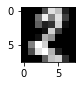

In [6]:
fig = plt.figure(figsize=(2, 1))
plt.imshow(target_matrix, cmap=plt.cm.gray, interpolation='none')
plt.show()

8x8ピクセルなので荒くて分かりづらいですが，遠目で見ると「2」という数字に見えますよね．

### 学習

データの中身の理解が進んだので，K近傍法を用いて手書き数字画像の分類器を構築してみましょう．
授業でも説明したように，教師あり学習を行いモデル構築とモデル評価を行うには訓練データとテストデータが必要になります．

`sklearn`ライブラリには，データセットを訓練データとテストデータに分割する便利な関数`train_test_split`があります．
下記コードを実行して，手元にあるデータセットを「訓練データ」と「テストデータ」に分割してみましょう．


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, # データセットを訓練データ80%，テストデータ20%に分割
    shuffle=True,  # 分割時にはデータセットをシャッフル
    stratify=y)    # ラベルの分布が訓練データとテストデータで同じになるようにする

`train_test_split`関数の第1引数，第2引数にセットされた`X`と`y`について，
* 80%が訓練データ: `X_train`（画像データ）と`y_train`（対応するラベル）
* 20%がテストデータ: `X_test`（画像データ）と`y_test`（対応するラベル）

に分割されました．
本当にデータセットは80:20に分割されているか確認してみましょう．

In [8]:
print("訓練データのサイズ", len(y_train))
print("テストデータのサイズ", len(y_test))

訓練データのサイズ 1437
テストデータのサイズ 360


大体80:20に分割されていますね．

先の`train_test_split`関数の実行時には，stratify（層別化）オブションを有効にしていました．
ラベルの分布が訓練データとテストデータで同じになっているか，確認しておきましょう．
下記コードを実行します．

In [9]:
# 訓練データの分布
keys, counts = np.unique(y_train, return_counts=True)
for key, count in zip(keys, counts):
    print(key, ":", count)

0 : 142
1 : 145
2 : 142
3 : 146
4 : 145
5 : 146
6 : 145
7 : 143
8 : 139
9 : 144


In [10]:
# テストデータの分布
keys, counts = np.unique(y_test, return_counts=True)
for key, count in zip(keys, counts):
    print(key, ":", count)

0 : 36
1 : 37
2 : 35
3 : 37
4 : 36
5 : 36
6 : 36
7 : 36
8 : 35
9 : 36


訓練データもテストデータも，0から9までの手書き数字データがほぼ均等に分布していることが確認できます．

それでは，K近傍法で手書き数字画像の分類器を構築しましょう．
MNISTデータセットはデータがキレイなため，特に前処理を行わなくても`sklearn`ライブラリを使えば分類器の構築は数行で終わってしまいます．

今回はK近傍法のパラメータは
* 近傍数`K`: 5
* 距離関数`metric`: euclidean（ユークリッド距離）

とし，以下のコードを実行して分類器を構築してみましょう．

In [11]:
K = 5
knn_model = KNeighborsClassifier(n_neighbors=K, metric="euclidean")
knn_model.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean')

K近傍法による分類器が構築できました．

それではテストデータから適当にピックアップし，分類器で正しく数値分類できるか確認してみましょう．
下記コードを実行すると，テストデータからランダムに3個データを取得し分類器を適用します．

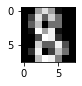

予測ラベル:  [8]
正解ラベル:  8


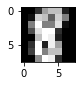

予測ラベル:  [8]
正解ラベル:  8


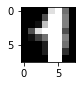

予測ラベル:  [1]
正解ラベル:  1


In [12]:
import random

test_size = len(y_test)
for _ in range(3):
    idx = random.randint(0, test_size-1) # 何番目のテストデータか
    target_data = X_test[idx, :].reshape(1, 64)
    target_label = y_test[idx]

    # K近傍法による推論
    y_predicted = knn_model.predict(target_data)

    # 手書き数字画像を表示
    fig = plt.figure(figsize=(2, 1))
    plt.imshow(target_data.reshape(8, 8), cmap=plt.cm.gray, interpolation='none')
    plt.show()
    
    # 推論結果と正解ラベルの表示
    print("予測ラベル: ", y_predicted)
    print("正解ラベル: ", target_label)

分類結果はいかがでしたか．（位置が調整された）手書き数字画像であれば，K近傍法は驚くべきほど正確にラベルを予測することが確認できたのではないでしょうか．

---
## 例題2: 人工的に作られたある2次元データ

次の例題では，機械学習の手順や評価指標の重要性を体験してみましょう．
この例題で用いるのは，この例題のために作成した二次元データです．
データの値に特に意味はありません．

以下のコードを実行して，データを読み込んでください．

In [13]:
url = "https://raw.githubusercontent.com/hontolab-courses/dmml-2021/main/dataset/imbalanced-data.tsv"
scatter_df = pd.read_table(url, header=0, sep='\t')
scatter_df

,label,x1,x2
0,0,10.922188,11.037222
1,0,5.560963,-1.993854
2,1,-0.172181,2.659002
3,0,9.094238,-0.180836
4,0,-1.802328,5.721992
...,...,...,...
103,1,-2.940544,5.098511
104,0,8.265318,11.367254
105,1,4.993353,8.362569
106,0,8.472310,11.346936


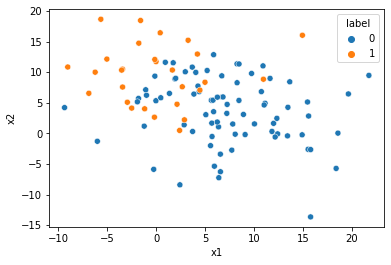

In [14]:
sns.scatterplot(x='x1', y='x2', hue='label', data=scatter_df)
plt.show()

変数`scatter_df`には，ラベル0とラベル1のデータ点が合計108個格納されています．
ラベルの分布を以下のコードを実行して確認してみましょう．

In [15]:
keys, counts = np.unique(scatter_df.label, return_counts=True)
for key, count in zip(keys, counts):
    print("Label", key, "=", count)

Label 0 = 80
Label 1 = 28


偏っていますね．ラベル1のデータがラベル0の3分の1程度しかありません．

ではK近傍法を用いて，ラベルの分類器を構築してみましょう．
この例題では`K=5`としてK近傍法を用います．
今回はまず**誤った手続き**で分類器を構築・評価してみます．

### 誤った手続き1: 交差検証を行わない

誤った手続きその1は「交差検証を行わない」です．
用意したデータセットのサイズが十分に大きい場合，あるいはデータセットの準備の時点で訓練データとテストデータが分けて得られている場合は交差検証にこだわる必要はそれほどないかもしれません．
そうでない場合は，交差検証をしなければ，分類器の汎化性能および性能評価そのものに問題が生じます．

以下は交差検証を行わない，誤った教師あり学習の手続きです．

In [16]:
# データ準備
X = scatter_df[scatter_df.columns[1:]]
y = scatter_df[scatter_df.columns[0]]

# データセットを70:30で訓練データ，評価データに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# K近傍法のモデルの定義
K = 5
knn_model = KNeighborsClassifier(n_neighbors=K, metric="euclidean")

# 学習
knn_model.fit(X_train, y_train)

# 推論
y_predicted = knn_model.predict(X_test)

# 評価
accuracy = accuracy_score(y_test, y_predicted)
print("kNN accuracy: ", accuracy)

kNN accuracy:  0.8484848484848485


評価指標として精度（accuracy）を用いて，交差検証を行わずに分類器の構築と評価を行っています．
みなさんの環境では適合率はいくつになったでしょうか．
他の人と比べたり上記コードを再度実行してみてください．
適合率が大きく異なることに気付くはずです．

十分に大きくないデータセットに対して**交差検証を用いない場合，訓練データとテストデータの中身の分布に偏りが生じます**．
その影響がモデルの構築および性能評価に出て，偶然結果が良くなったり悪くなったりします．
分割した訓練データと評価データのラベルの分布を確認してみましょう．


In [17]:
# 訓練データの分布
keys, counts = np.unique(y_train, return_counts=True)
for key, count in zip(keys, counts):
    print("Label", key, "=", count)

Label 0 = 57
Label 1 = 18


In [18]:
# テストデータの分布
keys, counts = np.unique(y_test, return_counts=True)
for key, count in zip(keys, counts):
    print("Label", key, "=", count)

Label 0 = 23
Label 1 = 10


今回は`train_test_split`関数を用いるときにランダムにテストデータを分割しているため，人によっては訓練データとテストデータのラベルの分布が同じようになったケースもあるかもしれません．
偶然を防ぎ汎化性能を向上させるためにも，交差検証を行う必要があります．

さて，上記の「誤った手続き」のコードは，交差検証のやり方以外にも問題があります．
次の「誤った手続き」で見てみましょう．

### 誤った手続き2: 層別化を行わない

誤った手続きその2は「層別化を行わない」です．
今回用意したデータセットのようにラベルの分布に偏りがある場合は，その分布を考慮して訓練データとテストデータを分割しなければ，たまたま都合の良い（あるいは悪い）分類器を構築し，たまたま都合の良い（あるいは悪い）性能評価を行ってしまいます．
そのため，**層別化**を行いながら訓練データとテストデータの分割を行う必要があります．

以下は層別化を行わない交差検証を行った，誤った教師あり学習の手続きです．

In [19]:
# データセットの準備
X = scatter_df[scatter_df.columns[1:]]
y = scatter_df[scatter_df.columns[0]]

# 層別化をしない5分割交差検証の準備（乱数を固定）
k_fold = KFold(n_splits=5, shuffle=True, random_state=12345)

# 評価指標（精度）
score_funcs = ['accuracy']

# K近傍法のモデルの定義
K = 5
knn_model = KNeighborsClassifier(n_neighbors=K, metric="euclidean")

# 交差検証をしながら分類器を構築・評価
scores = cross_validate(knn_model, X, y, cv=k_fold, scoring=score_funcs)
print("Accuracy list: ", scores['test_accuracy'])

# 交差検証の評価スコアを平均としてまとめる
print("kNN accuracy: ", np.mean(scores['test_accuracy']))

Accuracy list:  [0.86363636 0.63636364 0.90909091 0.76190476 0.9047619 ]
kNN accuracy:  0.8151515151515152


上記コードではデータ分割と交差検証，分類器構築，分類器評価を簡単にまとめて実行できる`cross_validate`関数を使っています．
5分割交差検証の1回（ラウンド）ごとの精度スコアが`scores['test_accuracy']`に格納されています．また，その平均値の計算も行っています．
一般に，交差検証を用いた性能評価ではこの平均値を用います．

もうお気づきのとおり，適合率のスコアが交差検証のラウンドごとに大きく異なりますよね．
層別化を行っていないからです．
これは交差検証の平均スコアだけを見ていては気付きません．
交差検証を行って学習と評価を複数回やったとしても，ラベル分布の偏りの影響を低減するにはもう一工夫必要となります．

### 誤った手続き3: 評価指標が適切でない

誤った手続きその3は「評価指標が適切でない」です．
以下は層別化交差検証を行ったが単純な精度を評価指標に使ってしまった，誤った教師あり学習の手続きです．

In [20]:
# データセットの準備
X = scatter_df[scatter_df.columns[1:]]
y = scatter_df[scatter_df.columns[0]]

# 「層別化」5分割交差検証の準備（乱数を固定）
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)

# 評価指標（精度）
score_funcs = ['accuracy']

# K近傍法のモデルの定義
K = 5
knn_model = KNeighborsClassifier(n_neighbors=K, metric="euclidean")

# 交差検証をしながら分類器を構築・評価
scores = cross_validate(knn_model, X, y, cv=k_fold, scoring=score_funcs)
print("Accuracy list: ", scores['test_accuracy'])

# 交差検証の評価スコアを平均としてまとめる
print("kNN accuracy: ", np.mean(scores['test_accuracy']))

Accuracy list:  [0.72727273 0.81818182 0.77272727 0.76190476 0.80952381]
kNN accuracy:  0.7779220779220779


「誤った手続き2」よりも精度のばらつきが小さくなりました．
これで平均値を取れば一見正しい評価をしたような気がしますが，この例題の冒頭で解説したラベル分布の話を思い出してください．
このデータセットはラベル0のほうがラベル1よりも3倍程度多く含んでいます．
極端な話として，分類器の予測結果が常に「ラベル0」を返したとしても，単純な精度は不当に高い値をはじき出してしまいます．
今回用意したデータセットのようにラベルの分布に偏りがある場合は，単純な精度ではなくラベル分布の偏りを考慮した**マクロ精度**や**AUC**，**MCC（マシューズ相関係数）**を用いる必要があります．

最後に「より妥当な手続き」のコードを以下に記しておきます．

### より妥当な手続き

In [21]:
# データセットの準備
X = scatter_df[scatter_df.columns[1:]]
y = scatter_df[scatter_df.columns[0]]

# 5分割「層別化」交差検証の準備（乱数を固定）
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)

# 評価指標（マクロ精度（balanced accuracy），AUC）
score_funcs = ['balanced_accuracy', 'roc_auc']

# K近傍法のモデルの定義
K = 5
knn_model = KNeighborsClassifier(n_neighbors=K, metric="euclidean")

# 交差検証をしながら分類器を構築・評価
scores = cross_validate(knn_model, X, y, cv=k_fold, scoring=score_funcs)
print("Balanced accuracy list: ", scores['test_balanced_accuracy'])
print("AUC list: ", scores['test_roc_auc'])

# 交差検証の評価スコアを平均としてまとめる
print()
print("Balanced accuracy: ", np.mean(scores['test_balanced_accuracy']))
print("AUC: ", np.mean(scores['test_roc_auc']))

Balanced accuracy list:  [0.65625    0.66666667 0.58333333 0.70625    0.66875   ]
AUC list:  [0.84375    0.765625   0.82291667 0.84375    0.84375   ]

Balanced accuracy:  0.65625
AUC:  0.8239583333333333


上記はラベルの分布を考慮した，より妥当な分類器の構築と性能評価の手続きです．
今回のデータの分類問題に対してK近傍法は優れていたのかを判断するには，他の分類器と比較をしなければ結論は出せません，分類器の構築および性能評価の流れはおおむね上記のような流れで行うと思っていただいてよいでしょう．

今後より高性能の分類器を構築するには
* データの変換（スケーリング，one-hotベクトル化）
* 欠損値への対応
* 特徴量選択
* パラメータチューニング

などが必要となります．

---
## 例題3: ある時期のアメリカ合衆国の年収調査データ
最後の例題で扱うデータは，[1994年に作成されたアメリカ合衆国の国勢調査のデータセット（一部）](https://archive.ics.uci.edu/ml/datasets/Adult)です．
機械学習の研究分野では著名なデータセットで通称"Adult Dataset"と呼ばれています．
このデータセットには，
* 年齢
* 職業クラス
* 最終学歴
* 教育年数
* 婚姻ステータス
* 職業
* 家族の構成
* 人種
* 性別
* 資産売却益
* 資産売却損
* 週の労働時間
* 母国
* 年収（年5万ドル以上（>=50K） or それ以下（<50K））

に関する情報が含まれています．
このデータセットを使って，年収以外の情報から年収が年5万ドル以上か未満かを推定するさまざまな分類器を構築してみましょう．

以下のコードを実行すると，不必要なデータ列を削除し，ターゲットとなる年収情報を
* 年5万ドル以上なら1
* 年5万ドル未満なら0

に置換したデータセットをデータフレーム変数`adult_df`に読み込みます．
早速実行してみてください．

In [22]:
adult_dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

features = [
    "age",             # 年齢（数値）
    "workclass",       # 職業クラス（カテゴリカル）
    "fnlwgt",          # 不明
    "education",       # 最終学歴（カテゴリカル）
    "education_num",   # 教育年数（数値）
    "marital_status",  # 婚姻ステータス（カテゴリカル）
    "occupation",      # 職業（カテゴリカル）
    "relationship",    # 家族の構成（カテゴリカル）
    "race",            # 人種（カテゴリカル）
    "sex",             # 性別（カテゴリカル）
    "capital_gain",    # 資産売却益（数値）
    "capital_loss",    # 資産売却損（数値）
    "hours_per_week",  # 週の労働時間？（数値）
    "native_country",  # 母国（カテゴリカル）
    "annual_income"    # 年収（True of False）
]

adult_df = pd.read_table(
    adult_dataset_url, sep=", ", header=None,
    names=features, engine='python', na_values="?"
).assign(
    has_high_salary = lambda df: df["annual_income"].map({">50K": True, "<=50K": False})
).drop( # 不要 or 不明な特徴量を削除
    columns=['fnlwgt', 'annual_income']
)

読み込んだ`adult_df`を以下のコードで表示してみましょう．
データは全部で32561レコードあることが分かります．

In [23]:
adult_df

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,has_high_salary
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,False
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,False
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,False
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,False
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,False
32557,40,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,True
32558,58,Private,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,False
32559,22,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,False


今回の分類対象となる年収の分布を確認しておきましょう．
下記コードを実行し，`adult_df`中の`has_high_salary`の値の分布を調べます．

In [24]:
keys, counts = np.unique(adult_df["has_high_salary"], return_counts=True)
for key, count in zip(keys, counts):
    ratio = count / len(adult_df) * 100
    print(key, ":", count, "({:.1f}%)".format(ratio))

False : 24720 (75.9%)
True : 7841 (24.1%)


年収が5万ドル以上のレコードと5万ドル未満のレコードの比は約1:3のようです．
データに偏りがあるので，この点を意識して分類器の構築・評価を行う必要があります．

では，先に進みましょう．
分類器を構築するためにはデータセットを特徴データとラベルデータに分ける必要がありました．
以下のコードを実行して特徴データを変数`X`に，ラベルデータを変数`y`に格納します．

In [25]:
# 最後の列の"has_high_salary"以外が特徴データ列
X = adult_df[adult_df.columns[:-1]] 

# ターゲットラベルは"has_high_salary"
y = adult_df["has_high_salary"] 

さて，`adult_df`を表示してお気づきのとおり，今回のデータセットには「年齢」「教育年数」「週の労働時間」のような**数値データ**もあれば，「職業クラス」「婚姻ステータス」「人種」のような**カテゴリカルデータ（質的データ）**も含まれています．
カテゴリカルデータは数値ではないので，そのままでは数値処理を行うのが難しいです．
そのため，機械学習を行うときにはカテゴリカルデータを**one-hotベクトル（one-hot表現，ダミー変数と呼ばれることもある）**に置き換えます．

例えば，

| ID | 年齢| 最終学歴 |
| --- | --- | --- |
| 1 | 38 | 大学 |
| 2 | 58 | 高校 |
| 3 | 27 | 大学院 |

のようなデータセットがあった場合，最終学歴がカテゴリカルデータに相当します．
このデータセットをOne-hotベクトル化すると，以下のようになります．

| ID | 年齢| 最終学歴_大学 | 最終学歴_高校 |
| --- | --- | --- | --- |
| 1 | 38 | 1 | 0 |
| 2 | 58 | 0 | 1 |
| 3 | 27 | 0 | 0 | 

今回のデータセットもone-hotベクトル化してみましょう．
`pandas`ライブラリには，データフレームの中で指定した列をone-hotベクトルに変換してくれる便利な関数`get_dummies`があります．
以下のコードを実行して，特徴データ`X`をone-hotベクトル化してみましょう．

In [26]:
# ターゲットとなるカテゴリカルデータの特徴名（列名）
categorical_features = [
    "workclass",       # 職業クラス（カテゴリカル）
    "education",       # 最終学歴（カテゴリカル）
    "marital_status",  # 婚姻ステータス（カテゴリカル）
    "occupation",      # 職業（カテゴリカル）
    "relationship",    # 家族の構成（カテゴリカル）
    "race",            # 人種（カテゴリカル）
    "sex",             # 性別（カテゴリカル）
    "native_country",  # 母国（カテゴリカル）    
]

# Xのカテゴリカルデータ列をone-hotベクトル化
X_ = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# 最初の10件を表示
X_.head()

,age,education_num,capital_gain,capital_loss,hours_per_week,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,native_country_Portugal,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia
0,39,13,2174,0,40,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,13,0,0,13,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,38,9,0,0,40,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,7,0,0,40,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,13,0,0,40,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


新たに得られたデータフレーム`X_`で`workclass`に関連する列に着目してみてください．
元々は列`workclass`の値として"Local-gov"や"Never_worked"がありましたが，one-hotベクトル化されたデータフレーム`X_`では`workclass_Local-gov`などの列が新たに生成されています．

カテゴリカルデータに対する前処理が終わりましたが，まだ分類器を構築することはできません．
データの正規化を行う必要があります．

One-hotベクトルは1もしくは0の値を取ります．
一方で，データフレーム`X_`には「年齢」「週の勤務時間」「資産売却益」など，連続値を取る特徴量があります．
これらの特徴量はとり得る値の範囲やデータの分布，単位が特徴量ごとに大きく異なるため，特徴量（列）間の比較が難しくなり，機械学習の性能に悪影響が出る可能性があります．
このような問題に対処するために，データの**スケーリング**を行いましょう．

一般に，スケーリングの方法には
* 正規化: 最小値-最大値でスケーリングする方法
* 標準化: データの分布が平均0，標準偏差1になるようスケーリングする方法

の2種類がよく用いられます．
ここでは簡単のため，連続値データ列もone-hotベクトルデータ列もすべて標準化することにしましょう．
以下のコードでデータを標準化します．


In [27]:
# 標準化のための変換器を用意
scaler = preprocessing.StandardScaler()

# 標準化
X_ = pd.DataFrame(scaler.fit_transform(X_), columns=X_.columns)

データフレーム`X_`のデータが標準化されました．

前処理が終わったので，いよいよ分類器を構築しましょう．
今回は
* ロジスティック回帰
* 決定木
* K近傍法（K=5）

の3種類の分類器を構築します．
簡単のため，ロジスティック回帰および決定木はデフォルトパラメータで分類器を構築します．
また，分類器の性能評価は5分割の層別化交差検証，評価指標は「マクロ精度（balanced accuracy）」「適合率（precision）」の2つを用いることにします．

やや長いですが，下記コードを実行し，交差検証を用いて分類器の構築，性能評価をしてみましょう．

In [28]:
# 時間計測に使う
import time

# 評価スコアを入れる場所
accuracy_scores = {'logistic_regression': [],
                   'decision_tree': [],
                   'kNN': []}
precision_scores = {'logistic_regression': [],
                    'decision_tree': [],
                    'kNN': []}

training_runtimes = {'logistic_regression': [],
                     'decision_tree': [],
                     'kNN': []}

prediction_runtimes = {'logistic_regression': [],
                       'decision_tree': [],
                       'kNN': []}

# 5分割層別化交差検証
kfold = StratifiedKFold(n_splits=5, shuffle=True)
for train_idx, test_idx in kfold.split(X_, y):
    # train_idx, test_idxには，データフレーム中の何番目のデータを用いるかの
    # リストが入っている．
    # 3つの分類器に対して同じデータを用いて評価すること．
    X_train = X_.iloc[train_idx]
    X_test = X_.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]
    
    for clf_name in ['logistic_regression', 'decision_tree', 'kNN']:
        if clf_name == 'logistic_regression':
            # ロジスティック回帰
            model = LogisticRegression()
        elif clf_name == 'decision_tree':
            # 決定木
            model = DecisionTreeClassifier(criterion='entropy')
        else:
            # K近傍法
            model = KNeighborsClassifier(n_neighbors=5, metric="euclidean")
        
        # 学習（実行時間を計測しておく）
        start_time = time.time()
        model.fit(X_train, y_train)
        training_runtimes[clf_name].append(time.time() - start_time)
        
        # 推論（実行時間を計測しておく）
        start_time = time.time()
        y_predicted = model.predict(X_test)
        prediction_runtimes[clf_name].append(time.time() - start_time)
        
        # 評価スコアの計算
        precision = precision_score(y_test, y_predicted)
        precision_scores[clf_name].append(precision)          
        accuracy = balanced_accuracy_score(y_test, y_predicted)
        accuracy_scores[clf_name].append(accuracy)
    
    
# 交差検証の結果を平均して，最終の性能評価を算出
print("\n==== Precision =====")
for method in precision_scores:
    print(method, ":", np.mean(precision_scores[method]))
    
print("\n==== Balanced accuracy =====")
for method in accuracy_scores:
    print(method, ":", np.mean(accuracy_scores[method]))


==== Precision =====
logistic_regression : 0.7323036621314223
decision_tree : 0.6345097718860878
kNN : 0.6576238564615403

==== Balanced accuracy =====
logistic_regression : 0.7642307284438956
decision_tree : 0.7529535586487652
kNN : 0.7402306815772401


評価に用いたデータには年収の分布に偏りがあったため，適合率よりもマクロ精度をより重視した方がよいでしょうが，今回のHands-onコードでは，適合率とマクロ精度の2つの評価指標ともに，ロジスティック回帰の評価値が最も高くなりました．
単純な手法であるK近傍法も，そこまで悪くない性能を示しています．
ハイパーパラメータの調整はしなかったので，どの分類器ももう少し性能改善の余地はあるでしょう．

最後に学習，推論にかかった時間の平均値も表示してみましょう．

In [29]:
print("\n==== Training runtime (s)=====")
for method in training_runtimes:
    print(method, ":", np.mean(training_runtimes[method]))
    
print("\n==== Prediction runtime (s)=====")
for method in prediction_runtimes:
    print(method, ":", np.mean(prediction_runtimes[method]))    


==== Training runtime (s)=====
logistic_regression : 0.36548709869384766
decision_tree : 0.12764859199523926
kNN : 0.001911020278930664

==== Prediction runtime (s)=====
logistic_regression : 0.0022450923919677735
decision_tree : 0.002618837356567383
kNN : 2.259625291824341


* ロジスティック回帰および決定木は，学習に時間がかかり推論は瞬時に終わる
* K近傍法は，学習は一瞬で終わり推論に非常に時間がかかっている

ことが確認できます．
最終的にはなにかしらの推論を行うために機械学習を用いるわけですから，推論に時間がかかると問題になるケースではK近傍法は割けた方がよいでしょう．
一方，推論の実行時間が気にならないのであれば，単純でもそこそこ性能を発揮するK近傍法は候補のひとつに入る可能性があるでしょう．